In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from statsmodels.tsa.seasonal import STL

import tqdm

# Baseline model

1. Train set: Use data from 7am - 17pm in train set
2. Test set: To evaluate, only evaluate prediction from 9am - 17pm 
3. Impute missing for all data by linear interpolation, fill forward and backward
4. Scale min max, fit train set
5. Train features to predict their futures by LSTM
6. Train features with response to predict response by Regression

In [21]:
data_dir = os.getcwd()
data = pd.read_csv(data_dir + '/data/add_lag_diff/loc_17.csv')

data_late, data_early, data_to_predict = prepare_dataset(data)

In [140]:
def time_decompose(data_col, period, season):
    stl = STL(data_col.fillna(data_col.mean()), period=period, seasonal=season)
    res = stl.fit()
    seasonal_component = res.seasonal
    col_deseason = data_col - seasonal_component

    return col_deseason, seasonal_component

def prepare_dataset(data):
    # Get the complete day only
    data['date'] = pd.to_datetime(data['DateTime']).dt.date
    record_counts = data.groupby('date').size()
    data = data[data['date'].isin(list(record_counts[record_counts == 60].index))]

    # get train data and input for test
    hour_dt = pd.to_datetime(data["DateTime"]).dt.time
    data_late = data[(hour_dt >= pd.to_datetime("09:00").time()) & 
                        (hour_dt < pd.to_datetime("17:00").time())]
    
    data_early = data[(hour_dt >= pd.to_datetime("07:00").time()) & 
                        (hour_dt < pd.to_datetime("09:00").time())]
    
    data_to_predict = data_late[data_late['to_predict'] == 1]
    print(data_to_predict.shape)
    data_to_predict = data_late

    # drop date with missing value 
    record_counts = data_late.groupby('date')['Power(mW)'].count()
    data_late = data_late[data_late['date'].isin(list(record_counts[record_counts == 48].index))]

    # record_counts = data_early.groupby('date')['Power(mW)'].count()
    # data_early = data_early[data_early['date'].isin(list(record_counts[record_counts == 12].index))]
    
    return data_late, data_early, data_to_predict

def impute_missing(data):
    """
    data: DataFrame
    """
    features = data.columns
    for feature in features:
        data[feature] = data[feature].interpolate(method='nearest', limit_direction='both')
        data[feature] = data[feature].ffill()
        data[feature] = data[feature].bfill()

    return data


def scale_min_max(fit_data):
    """
    train_set, test_set: numpy array
    """
    minmax_scaler = MinMaxScaler().fit(fit_data)
    data_scaled = minmax_scaler.transform(fit_data)

    return data_scaled, minmax_scaler


def feature_differencing(time_feature, lag):
    diff_feat = time_feature[:-lag]
    diff_feat = np.append(diff_feat.values[:lag], diff_feat)
    return diff_feat
    
    
def add_features(data, time_col):
    data['hour'] = pd.to_datetime(data[time_col]).dt.hour
    data['minute'] = pd.to_datetime(data[time_col]).dt.minute
    
    return data
    
    
def window_data(data, look_back_num):
    """
    data: numpy array
    """
    X_train = []
    y_train = []

    # # input X, each look_back_num points is corresponding to 1 y (y dim is 5)
    for i in range(look_back_num, data.shape[0]):
        X_train.append(data[i-look_back_num:i, :])
        y_train.append(data[i, :])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], data.shape[1]))  # num obs * time sequence length * num features

    return X_train, y_train


# Modelling

def lstm_model(X_train, y_train, epochs, batch_size):
    regressor = Sequential()
    regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))  # each input is time sequence length * num features
    regressor.add(LSTM(units = 64))
    regressor.add(Dropout(0.2))

    # output layer
    regressor.add(Dense(units=y_train.shape[1]))
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    # regressor.summary()
    history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose=True)

    return regressor, history

def train_model(train_set, look_back_num, epochs, batch_size):
    ## LSTM
    train_set = add_features(train_set, 'DateTime')
    train_set['power_lag1'] = feature_differencing(train_set['Power(mW)_log_deseason'], 1)
    # train_set['power_lag60'] = feature_differencing(train_set['Power(mW)'], 60)
    train_set['power_lag2'] = feature_differencing(train_set['Power(mW)_log_deseason'], 2)
    train_set['power_lag3'] = feature_differencing(train_set['Power(mW)_log_deseason'], 3)
    train_set['power_lag4'] = feature_differencing(train_set['Power(mW)_log_deseason'], 4)
    train_set['power_lag5'] = feature_differencing(train_set['Power(mW)_log_deseason'], 5)

    features = ['hour', 'minute', 'WindSpeed(m/s)_deseason', 'Pressure(hpa)_deseason',
                'Temperature(°C)_deseason',
                'Humidity(%)_deseason','Sunlight(Lux)_deseason', 
                'power_lag1', 
                'power_lag2', 'power_lag3', 'power_lag4', 'power_lag5',
                'Power(mW)_log_deseason']
    # features = ['Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
    X_features = features[:-1]
    
    # get log
#     train_set[features[1:]] = np.log(train_set[features[1:]] + 1)
    
    train_imputed = impute_missing(train_set[features])
    # train_imputed = train_set.dropna()
    # print(np.sum(np.isnan(train_imputed)))
    # train_imputed = train_set[features].dropna()
    train_scaled, minmax_scaler = scale_min_max(train_imputed[X_features])
    X_train, X_train_later = window_data(train_scaled, look_back_num)
    regressor, history = lstm_model(X_train, X_train_later, epochs, batch_size)

    ## CatBoost

    y_train = train_imputed[['Power(mW)_log_deseason']]
    y_train_scaled, y_scaler = scale_min_max(y_train)
    cat_params = dict(iterations=7000,
                      learning_rate=0.01,
                      depth=11,
                      l2_leaf_reg=30,
                      bootstrap_type='Bernoulli',
                      subsample=0.66,
                      loss_function='MAE',
                      eval_metric = 'MAE',
                      metric_period=100,
                      od_type='Iter',
                      od_wait=30,
                      task_type='GPU',
                      allow_writing_files=False,
                      )

    # Train a LightGBM model for the current fold
    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(
        train_scaled,
        y_train_scaled,
        early_stopping_rounds=100
    )
    
    return minmax_scaler, regressor, history, cat_model, y_scaler

In [141]:
def lstm_predict(model, forecast_num, look_back_num, input_data, to_predict):
    # Only apply for look_back_num = 12 and forecast_num = 48
    predictions = []
    # print(input_data.shape[0]/12)
    # print(to_predict.shape[0]/48)
    i = look_back_num
    while i < input_data.shape[0] + 1:
        # print(i)
        input_df = input_data[(i-look_back_num):i, :]
        input_seq = np.array(input_df).reshape(1, input_df.shape[0], input_df.shape[1])
        # print(input_seq)
        for _ in range(forecast_num):
            next_pred = model.predict(input_seq, verbose=False)
            predictions.append(next_pred[0])
            # print(predictions)
            input_seq = np.append(input_seq[:, 1:, :], [[next_pred[0]]], axis=1)

        print(len(predictions))
        i = i + look_back_num
        
    return np.array(predictions)


def predict_power(test_set, to_predict_data, forecast_num, look_back_num, lstm_regressor, cat_model, minmax_scaler):
    date_lst = to_predict_data['date'].unique()
    test_set = add_features(test_set, 'DateTime')
    test_set['power_lag1'] = feature_differencing(test_set['Power(mW)_log_deseason'], 1)
    test_set['power_lag2'] = feature_differencing(test_set['Power(mW)_log_deseason'], 2)
    test_set['power_lag3'] = feature_differencing(test_set['Power(mW)_log_deseason'], 3)
    test_set['power_lag4'] = feature_differencing(test_set['Power(mW)_log_deseason'], 4)
    test_set['power_lag5'] = feature_differencing(test_set['Power(mW)_log_deseason'], 5)
    # test_set['power_lag60'] = feature_differencing(test_set['Power(mW)'], 60)
    # test_set['is_missing'] = np.where(test_set['Power(mW)'].isna(), 1, 0)
    test_set = test_set[test_set['date'].isin(date_lst)]

    features = ['hour', 'minute', 'WindSpeed(m/s)_deseason', 'Pressure(hpa)_deseason',
                'Temperature(°C)_deseason',
                'Humidity(%)_deseason','Sunlight(Lux)_deseason', 
                'power_lag1', 
                'power_lag2', 'power_lag3', 'power_lag4', 'power_lag5', 
                'Power(mW)_log_deseason']
    # features = ['Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
    X_features = features[:-1]
    
    # get log
#     test_set[features[1:]] = np.log(test_set[features[1:]] + 1)
    
    test_imputed = impute_missing(test_set[features])
    test_scaled = minmax_scaler.transform(test_imputed[X_features])
    X_test_pred = lstm_predict(lstm_regressor, forecast_num, look_back_num, test_scaled, to_predict_data)

    y_pred = cat_model.predict(X_test_pred).reshape(to_predict_data.shape[0])
    # y_pred = np.exp(y_pred) - 1
#     y_test = np.exp(y_test) - 1

    return X_test_pred, y_pred


In [ ]:
data.columns

Index(['DateTime', 'LocationCode', 'Serial', 'to_predict', 'WindSpeed(m/s)',
       'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)',
       'Power(mW)', 'WindSpeed(m/s)_lag1', 'WindSpeed(m/s)_lag60',
       'WindSpeed(m/s)_diff1', 'WindSpeed(m/s)_diff60',
       'WindSpeed(m/s)_diff_1_60', 'WindSpeed(m/s)_log',
       'WindSpeed(m/s)_lag1_log', 'WindSpeed(m/s)_lag60_log',
       'WindSpeed(m/s)_diff1_log', 'WindSpeed(m/s)_diff60_log',
       'WindSpeed(m/s)_diff_1_60_log', 'Pressure(hpa)_lag1',
       'Pressure(hpa)_lag60', 'Pressure(hpa)_diff1', 'Pressure(hpa)_diff60',
       'Pressure(hpa)_diff_1_60', 'Pressure(hpa)_log',
       'Pressure(hpa)_lag1_log', 'Pressure(hpa)_lag60_log',
       'Pressure(hpa)_diff1_log', 'Pressure(hpa)_diff60_log',
       'Pressure(hpa)_diff_1_60_log', 'Temperature(°C)_lag1',
       'Temperature(°C)_lag60', 'Temperature(°C)_diff1',
       'Temperature(°C)_diff60', 'Temperature(°C)_diff_1_60',
       'Temperature(°C)_log', 'Temperature(°C)

In [142]:
features = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)_log']
location_lst = range(1, 2, 1)
look_back_num = 12
forecast_num = 48
data_dir = os.getcwd()

all_predictions = pd.DataFrame(columns = ["serial", "y_pred"])
for loc in location_lst:
    print(loc, "----------------------------------------------------------------------------------------------------")
    data = pd.read_csv(data_dir + f'/data/add_lag_diff/loc_{loc}.csv')
    for feat in features:
        data[f'{feat}_deseason'], data[f'{feat}_season_comp'] = time_decompose(data[feat], 60*30, 61)

    data_late, data_early, data_to_predict = prepare_dataset(data)
    minmax_scaler, regressor, history, lin_reg, y_scaler = train_model(data_late, look_back_num=look_back_num, epochs=500, batch_size=128)
    X_test_pred, y_pred = predict_power(data_early, data_to_predict,  
                                         forecast_num=forecast_num, look_back_num=look_back_num,
                                         lstm_regressor=regressor, cat_model=lin_reg, minmax_scaler=minmax_scaler)
    y_pred_norm = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    # y_pred_norm = np.exp(y_pred_norm) - 1

    df = pd.DataFrame(columns = ["serial", "y_pred"])
    df['serial'] = data_to_predict['Serial']
    df['y_pred'] = (y_pred_norm + data_to_predict['Power(mW)_log_season_comp']).values

    all_predictions = pd.concat([all_predictions, df])

1 ----------------------------------------------------------------------------------------------------
(1152, 89)
Epoch 1/500
41/41 [==============================] - 3s 5ms/step - loss: 0.0772
Epoch 2/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 3/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 4/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0275
Epoch 5/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 6/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 7/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 8/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 9/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 10/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 11/500
41/41 [==============================] - 0s 5ms/step - loss: 0.0112
Epoc

100:	learn: 0.0270965	total: 1.75s	remaining: 1m 59s
200:	learn: 0.0240544	total: 3.56s	remaining: 2m
300:	learn: 0.0222837	total: 5.29s	remaining: 1m 57s
400:	learn: 0.0205256	total: 7.42s	remaining: 2m 2s
500:	learn: 0.0192721	total: 9.31s	remaining: 2m
600:	learn: 0.0176854	total: 11.7s	remaining: 2m 4s
700:	learn: 0.0162618	total: 14.3s	remaining: 2m 8s
800:	learn: 0.0151077	total: 16.9s	remaining: 2m 10s
900:	learn: 0.0139727	total: 19.6s	remaining: 2m 12s
1000:	learn: 0.0128794	total: 23.6s	remaining: 2m 21s
1100:	learn: 0.0119284	total: 27.8s	remaining: 2m 28s
1200:	learn: 0.0109913	total: 32.4s	remaining: 2m 36s
1300:	learn: 0.0101000	total: 37s	remaining: 2m 42s
1400:	learn: 0.0092976	total: 41.7s	remaining: 2m 46s
1500:	learn: 0.0086064	total: 46.3s	remaining: 2m 49s
1600:	learn: 0.0079684	total: 50.9s	remaining: 2m 51s
1700:	learn: 0.0073188	total: 55.6s	remaining: 2m 53s
1800:	learn: 0.0068515	total: 1m	remaining: 2m 53s
1900:	learn: 0.0063861	total: 1m 4s	remaining: 2m 54s

In [132]:
output = pd.read_csv("upload(no answer).csv")

In [134]:
output = output.merge(all_predictions, left_on='序號', right_on='serial')

In [137]:
output['答案'] = output['y_pred']
output[['序號', '答案']].to_csv('output_stl.csv', index=False)

In [148]:
X_test_pred_norm = minmax_scaler.inverse_transform(X_test_pred)
# y_pred_norm = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

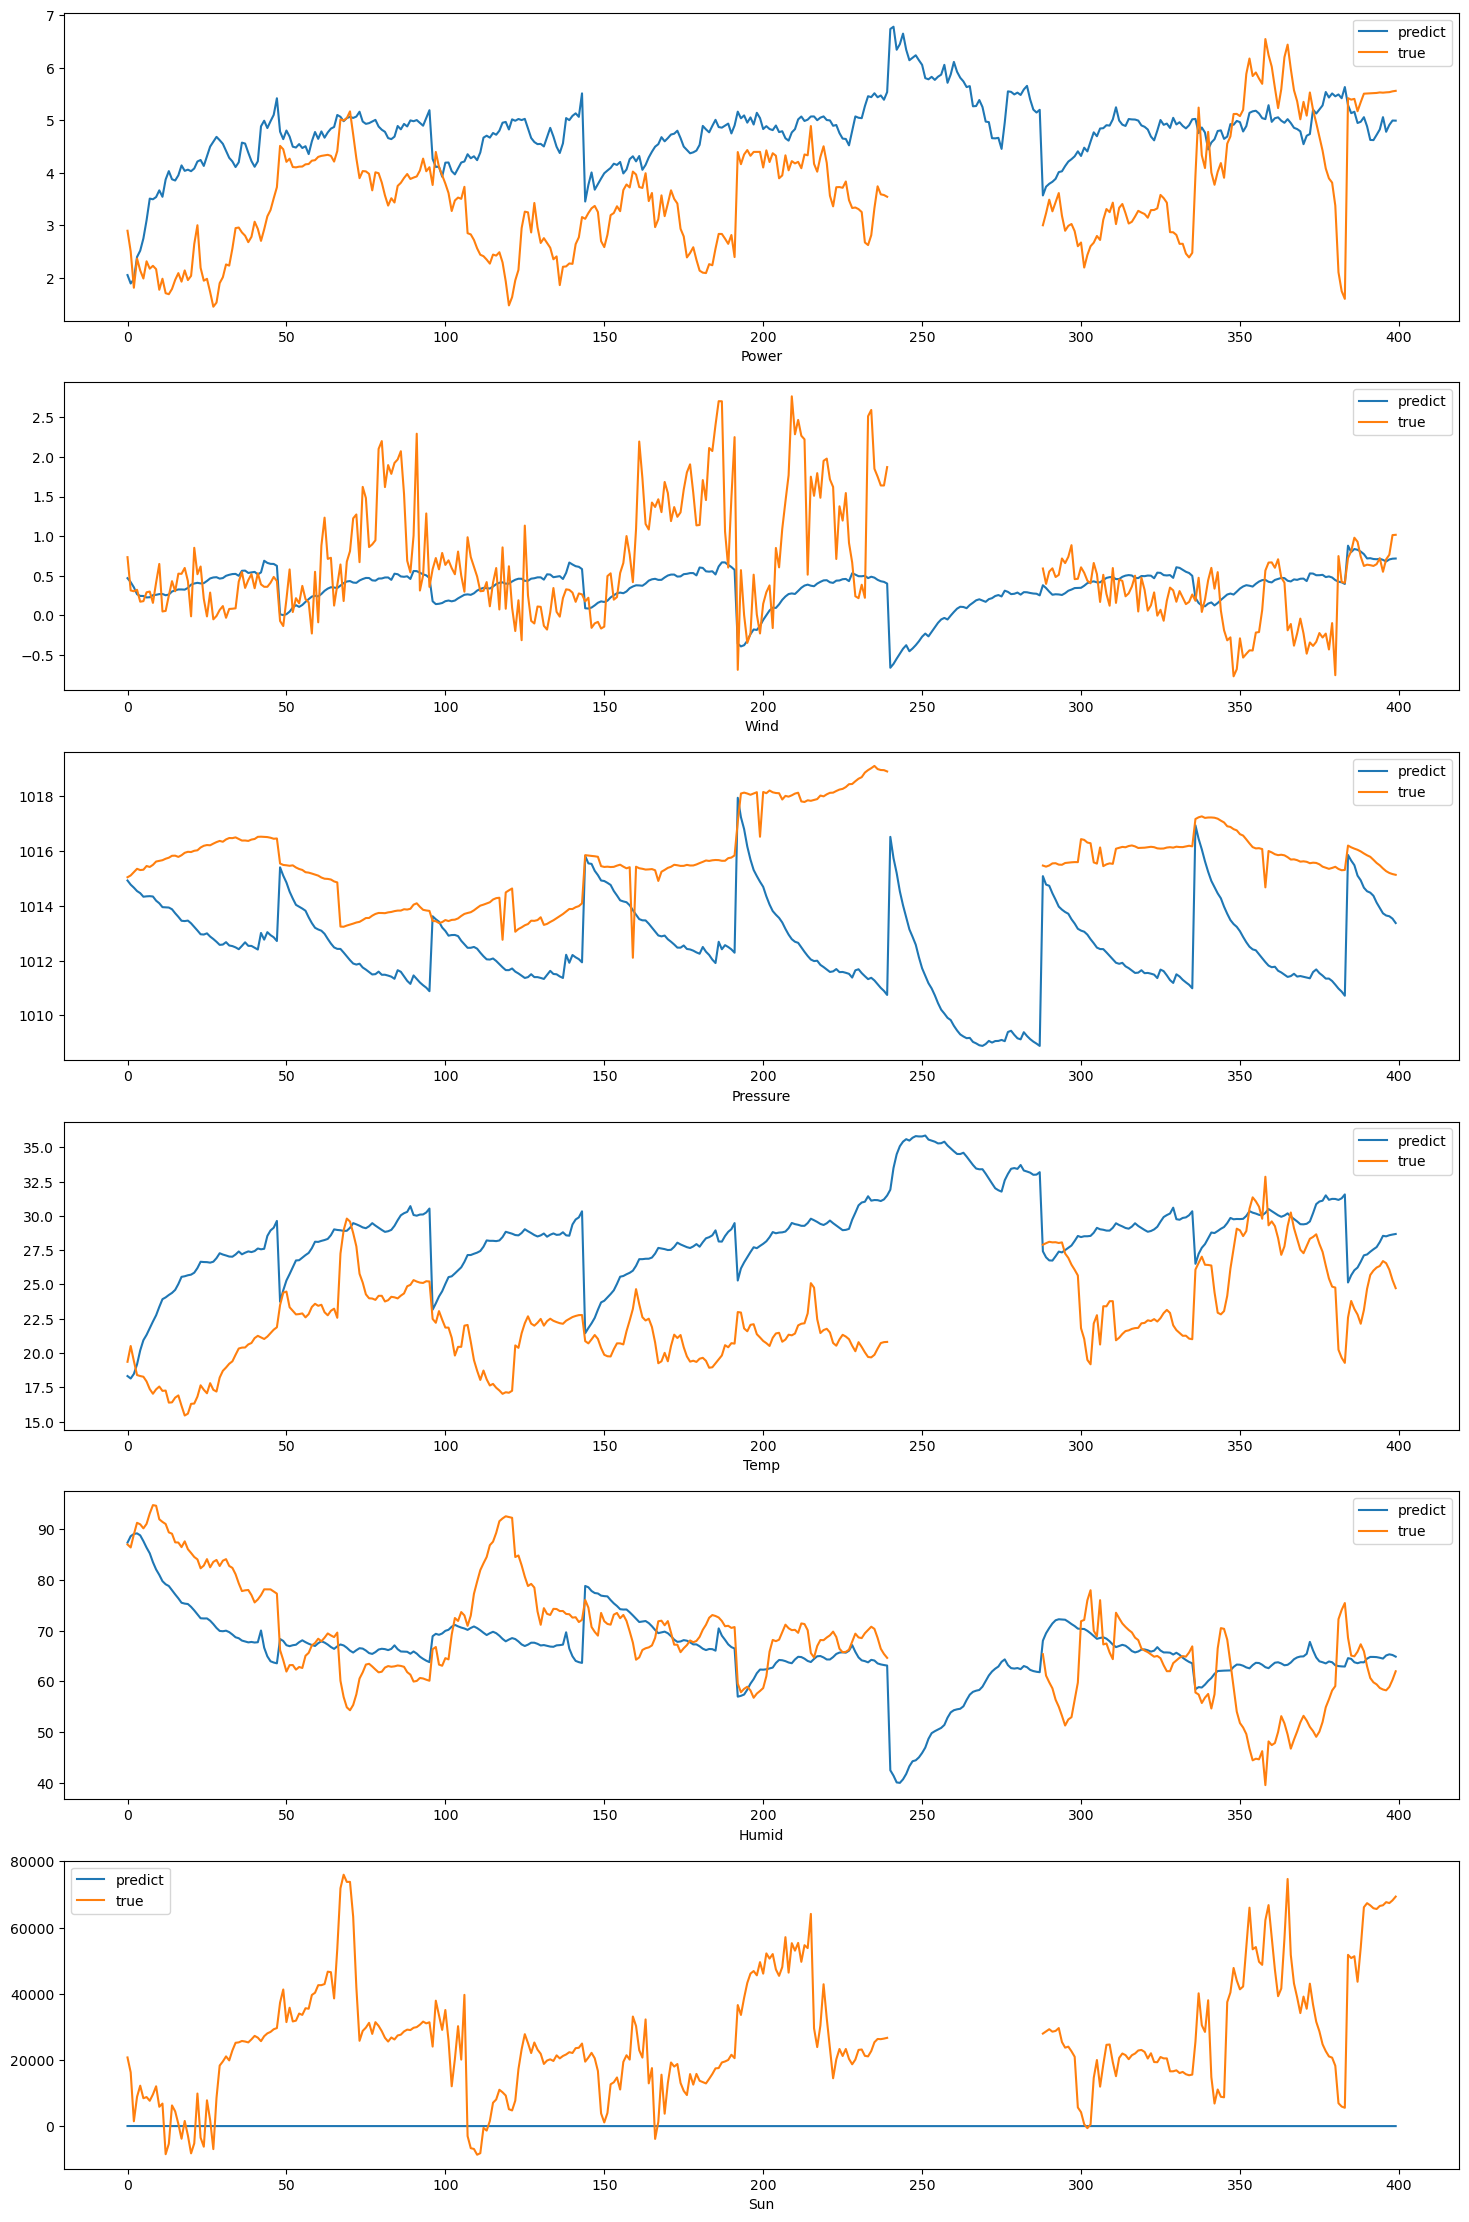

In [ ]:
# y_test = data_to_predict['Power(mW)'].values
# y_pred = (np.exp(df['y_pred']) - 1).values
y_test = data_to_predict['Power(mW)_log_deseason'].values
y_pred = y_pred_norm
# y_pred_season = (y_pred_norm.reshape(-1) + data_to_predict['Power(mW)_season_comp']).values

plt.figure(figsize=(18, 28))

plt.subplot(6, 1, 1)
plt.plot(y_pred[:400], label='predict')
plt.plot(y_test[:400], label='true')
plt.ylabel('Power')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(X_test_pred_norm[:400, 2], label='predict')
plt.plot(data_to_predict['WindSpeed(m/s)_deseason'].values[:400], label='true')
plt.ylabel('Wind')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(X_test_pred_norm[:400, 3], label='predict')
plt.plot(data_to_predict['Pressure(hpa)_deseason'].values[:400], label='true')
plt.ylabel('Pressure')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(X_test_pred_norm[:400, 4], label='predict')
plt.plot(data_to_predict['Temperature(°C)_deseason'].values[:400], label='true')
plt.ylabel('Temp')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(X_test_pred_norm[:400, 5], label='predict')
plt.plot(data_to_predict['Humidity(%)_deseason'].values[:400], label='true')
plt.ylabel('Humid')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(X_test_pred_norm[:400, 5], label='predict')
plt.plot(data_to_predict['Sunlight(Lux)_deseason'].values[:400], label='true')
plt.ylabel('Sun')
plt.legend()


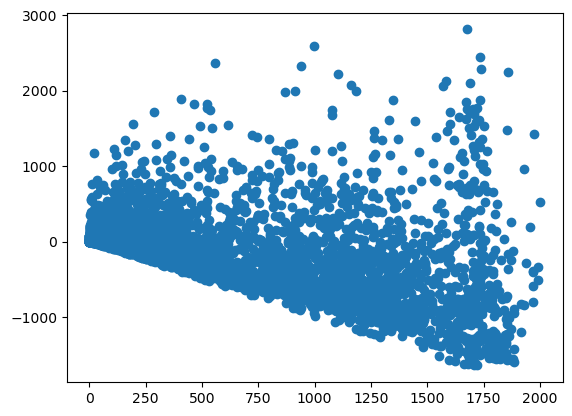

In [146]:
plt.scatter(y_test, y_pred - y_test)  

In [27]:
df

,datetime,location,y_test,y_pred,serial
12,2024-01-01 09:00:00,1,17.368000,25.128813,20240101090001
13,2024-01-01 09:10:00,1,12.612000,63.925981,20240101091001
14,2024-01-01 09:20:00,1,8.807000,115.718400,20240101092001
15,2024-01-01 09:30:00,1,17.564000,180.684807,20240101093001
16,2024-01-01 09:40:00,1,7.508000,204.284762,20240101094001
...,...,...,...,...,...
12355,2024-07-24 16:10:00,1,0.146000,16.648295,20240724161001
12356,2024-07-24 16:20:00,1,0.106000,16.354769,20240724162001
12357,2024-07-24 16:30:00,1,0.054000,16.471685,20240724163001
12358,2024-07-24 16:40:00,1,0.025556,16.537115,20240724164001


In [18]:
mae = np.mean(np.abs(all_predictions['y_test'] - all_predictions['y_pred']))
mae

455.64363979339225

In [19]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

470.19489577111347

In [15]:
## Retrain 3 because it looks weird

loc=3
minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=300, batch_size=512)
X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                         forecast_num=forecast_num, lstm_regressor=regressor, 
                                                         lin_reg=lin_reg, minmax_scaler=minmax_scaler)
df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
df["datetime"] = date_miss['DateTime']
df["is_missing"] = date_miss['is_missing']
df["location"] = loc
df["y_test"] = y_test
df["y_pred"] = y_pred
print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

MAE of location 3:  1590.1381620925763


In [17]:
# all_predictions = all_predictions.reset_index(drop=True)
all_predictions.loc[all_predictions['location'] == 3, :] = df

In [144]:
all_predictions.loc[11767:12858, 'location'] = 12

In [149]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

432.3412562823701

In [150]:
all_predictions.to_csv("output/output_lag1.csv", index=False)

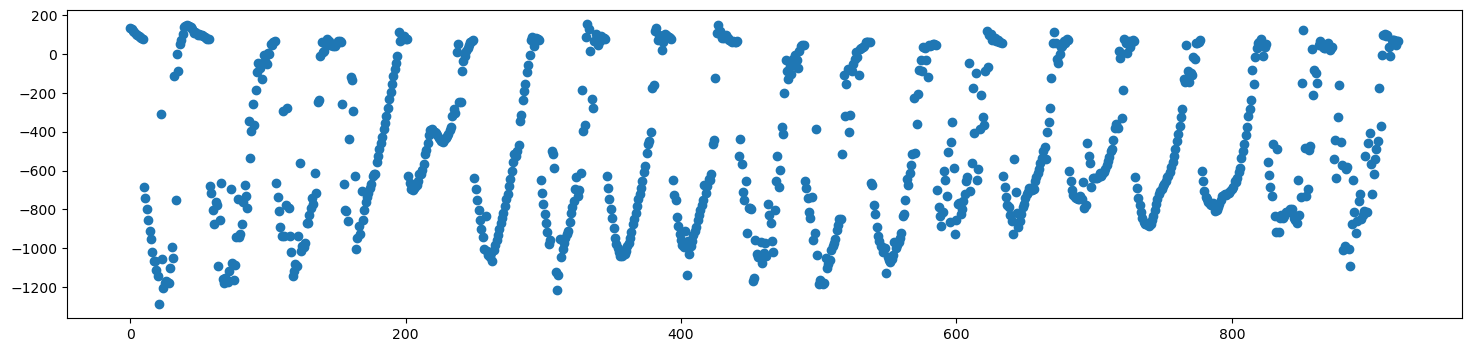

In [21]:
plt.figure(figsize=(18, 28))
y_ax = no_missing.loc[no_missing['location'] == 2, 'y_pred'] - no_missing.loc[no_missing['location'] == 2, 'y_test'] 

plt.subplot(6, 1, 1)
# plt.plot(np.arange(2000), np.arange(2000))
plt.scatter(np.arange(len(y_ax)), y_ax)

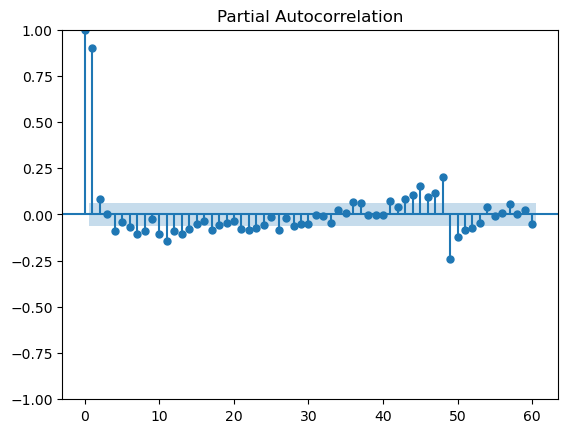

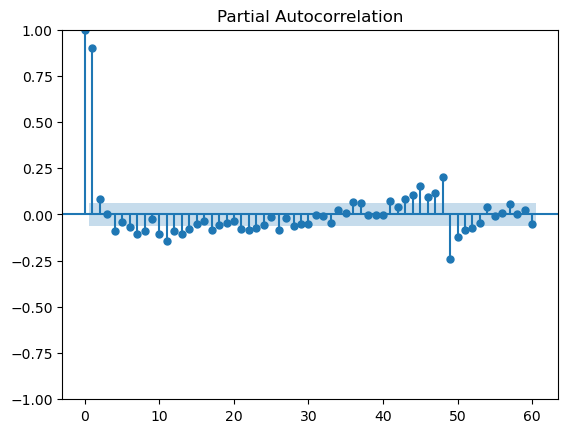

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot_pacf(y_ax, lags=60)

In [101]:
no_missing.loc[no_missing['location'] == 5, 'y_test'].shape

(576,)

# Baseline (without windspeed)

In [7]:
location_lst = range(1, 18, 1)
look_back_num = 12
forecast_num = 48

all_predictions = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred"])
for loc in location_lst:
    print(loc)
    minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=500, batch_size=512)
    X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                             forecast_num=forecast_num, lstm_regressor=regressor, 
                                                             lin_reg=lin_reg, minmax_scaler=minmax_scaler)
    df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
    df["datetime"] = date_miss['DateTime']
    df["is_missing"] = date_miss['is_missing']
    df["location"] = loc
    df["y_test"] = y_test
    df["y_pred"] = y_pred
    print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

    all_predictions = pd.concat([all_predictions, df])

1
MAE of location 1:  2565.461643806146
2
MAE of location 2:  362.86356925642275
3
MAE of location 3:  1441.455912933955
4
MAE of location 4:  659.2662560568165
5
MAE of location 5:  748.7796853483253
6
MAE of location 6:  562.2626608133307
7
MAE of location 7:  966.483484117751
8
MAE of location 8:  161.8023780989333
9
MAE of location 9:  230.6848413639127
10
MAE of location 10:  1092.0922996320612
11
MAE of location 11:  15.014703090918925
12
MAE of location 12:  510.9939710950664
13
MAE of location 13:  531.0760744192472
14
MAE of location 14:  425.99017836995523
15
MAE of location 15:  553.1719322121623
16
MAE of location 16:  588.081290298157
17
MAE of location 17:  473.2310054823779


In [8]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

764.8591096328307

In [9]:
all_predictions.to_csv("output/output_baseline_no_wind.csv", index=False)

In [11]:
train_file = os.path.join(os.getcwd(), "avg_data_10min_wh/loc_{i}/fold_4/train.csv".format(i=1))
train_set = pd.read_csv(train_file, encoding='utf-8')
train_set.head()

,DateTime,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-01-01 07:00:00,1.0,0.00000,1016.730,17.50,86.99,470.834,0.083
1,2024-01-01 07:10:00,1.0,0.00000,1016.774,17.57,86.97,659.667,0.139
2,2024-01-01 07:20:00,1.0,0.68193,1016.922,17.63,86.18,889.666,0.247
3,2024-01-01 07:30:00,1.0,0.60737,1016.992,17.74,85.41,1263.833,0.447
4,2024-01-01 07:40:00,1.0,0.00000,1017.094,17.90,85.41,2136.833,1.129


In [13]:
train_set['DateTime']

0        2024-01-01 07:00:00
1        2024-01-01 07:10:00
2        2024-01-01 07:20:00
3        2024-01-01 07:30:00
4        2024-01-01 07:40:00
                ...         
10315    2024-06-20 16:10:00
10316    2024-06-20 16:20:00
10317    2024-06-20 16:30:00
10318    2024-06-20 16:40:00
10319    2024-06-20 16:50:00
Name: DateTime, Length: 10320, dtype: object